In [ ]:
%pip install catboost

In [3]:
import pandas as pd
from tqdm import tqdm
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [7]:
df = pd.read_pickle('football_model_processed.pickle')
df

,under_pressure,shot_open_goal,shot_first_time,shot_one_on_one,shot_outcome_encoded,player_x,player_y,distance_from_goal_center,distance_from_goal_left_post,distance_from_goal_right_post,...,play_pattern_regular_play,shot_type_free_kick,shot_type_open_play,goalkeeper_x,goalkeeper_y,gk_distance_from_goal_center,gk_distance_from_goal_left_post,gk_distance_from_goal_right_post,shot_angle,distance_player_gk
0,0,0,1,0,0,108.1,31.2,14.800338,12.831602,17.477128,...,1,0,1,119.0,38.7,1.640122,2.879236,5.393515,0.438419,13.231024
1,0,0,1,0,1,110.9,42.6,9.464143,11.241441,9.207063,...,0,0,1,116.0,42.0,4.472136,7.211103,4.472136,0.780138,5.135173
2,1,0,1,0,0,117.9,29.1,11.100450,7.212489,15.047259,...,0,0,1,118.6,39.2,1.612452,3.492850,5.000000,0.155423,10.124228
3,0,0,0,0,1,101.8,27.6,22.022716,20.044949,24.498980,...,0,0,1,97.0,26.8,26.518673,24.771758,28.720028,0.301014,4.866210
4,0,0,0,0,0,109.3,26.5,17.226143,14.308739,20.511948,...,1,0,1,118.3,36.5,3.891015,1.772005,7.690254,0.295954,13.453624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45714,1,0,0,0,0,98.6,40.4,21.403738,21.847654,21.700691,...,1,0,1,117.4,39.9,2.601922,4.687217,4.854894,0.369445,18.806648
45715,0,0,1,0,0,103.0,51.3,20.412986,22.871161,18.501081,...,0,0,1,115.9,42.2,4.652956,7.433034,4.477723,0.327214,15.786703
45716,0,0,1,0,0,103.8,51.4,19.809089,22.351734,17.810109,...,0,0,1,116.3,42.0,4.205948,7.049113,4.205948,0.331601,15.640013
45717,0,0,0,0,0,110.0,39.4,10.017984,10.562197,11.007270,...,0,0,1,117.5,41.0,2.692582,5.590170,3.905125,0.758877,7.668768


In [8]:
X = df.drop(columns = {'shot_outcome_encoded','body_part_other','shot_technique_lob','play_pattern_other','shot_type_free_kick', 'distance_from_goal_left_post','distance_from_goal_right_post','player_x','goalkeeper_x','gk_distance_from_goal_left_post',
       'gk_distance_from_goal_right_post'})
y = df['shot_outcome_encoded']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=123,
    stratify=y  # Keep same class distribution
)
X_train.shape, X_test.shape

((33888, 27), (11297, 27))

In [ ]:
cont_cols = [
    col for col in X_train.columns
    if pd.api.types.is_numeric_dtype(X_train[col])       # numeric
    and X_train[col].nunique() > 2              # not binary
]

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[cont_cols] = scaler.fit_transform(X_train[cont_cols])

X_test_scaled = X_test.copy()
X_test_scaled[cont_cols] = scaler.transform(X_test[cont_cols])

In [14]:
# Initialize the CatBoost classifier
# verbose=0 suppresses output during training. 'iterations' refers to the number of trees.
# You can adjust other parameters as needed, such as loss_function, eval_metric, etc.
cat_model = CatBoostClassifier(
    random_seed=123, # Set a random seed for reproducibility
    early_stopping_rounds=50 # Early stopping can be set here or managed within GridSearchCV
)
# Define the parameter grid to search
param_grid = {
    'iterations': [100, 200, 300], # Number of boosting iterations (trees)
    'learning_rate': [0.01, 0.1], # Step size shrinkage to prevent overfitting
    'depth': [4, 6, 8], # Depth of the trees
    'l2_leaf_reg': [1, 10] # L2 regularization coefficient
    # 'border_count': [32, 64, 128], # Number of splits for categorical features
    # 'subsample': [0.6, 0.8, 1.0] # Fraction of objects to be used for training at each iteration
}
# Initialize GridSearchCV
# estimator: The model to optimize
# param_grid: The parameter grid to search
# cv: Number of cross-validation folds
# scoring: Evaluation metric (e.g., 'roc_auc', 'accuracy', 'f1')
# n_jobs: Number of jobs to run in parallel (-1 means use all available CPU cores)
# verbose: Verbosity level (0: no output, 1: brief, 2: detailed)
grid_search = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid,
    cv=5,                 # Use 5-fold cross-validation; increase folds for more stable results, but it will increase computation time
    scoring='roc_auc',    # Select an appropriate evaluation metric, 'roc_auc' is common for binary classification
    n_jobs=-1,            # Use all available CPU cores for parallel computation
    verbose=2             # Display more detailed search process information
)

print("Starting GridSearchCV training...")
# Fit GridSearchCV on the training data
grid_search.fit(X_train_scaled, y_train)
print("GridSearchCV training completed.")

Starting GridSearchCV training...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
0:	learn: 0.5910284	total: 59.4ms	remaining: 11.8s
1:	learn: 0.5105841	total: 68.3ms	remaining: 6.76s
2:	learn: 0.4519755	total: 76.9ms	remaining: 5.05s
3:	learn: 0.4099750	total: 84.2ms	remaining: 4.13s
4:	learn: 0.3782375	total: 91.5ms	remaining: 3.57s
5:	learn: 0.3522667	total: 98.8ms	remaining: 3.19s
6:	learn: 0.3340917	total: 106ms	remaining: 2.93s
7:	learn: 0.3179739	total: 114ms	remaining: 2.72s
8:	learn: 0.3081730	total: 121ms	remaining: 2.57s
9:	learn: 0.2984145	total: 128ms	remaining: 2.44s
10:	learn: 0.2917615	total: 136ms	remaining: 2.34s
11:	learn: 0.2848845	total: 144ms	remaining: 2.25s
12:	learn: 0.2799021	total: 151ms	remaining: 2.18s
13:	learn: 0.2759346	total: 159ms	remaining: 2.11s
14:	learn: 0.2728098	total: 166ms	remaining: 2.05s
15:	learn: 0.2699945	total: 174ms	remaining: 2s
16:	learn: 0.2676905	total: 182ms	remaining: 1.96s
17:	learn: 0.2660216	total: 189ms	remaining:

In [17]:
# Print the best parameters and best score found
print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score (ROC AUC): ", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

Best parameters:  {'depth': 4, 'iterations': 200, 'l2_leaf_reg': 10, 'learning_rate': 0.1}
Best cross-validation score (ROC AUC):  0.8100853505457378


In [18]:
# Evaluate on TEST SET (the held-out 25%)
print("\n" + "="*50)
print("Test Set Performance:")
print("="*50)

# Predict probabilities
y_test_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
y_test_pred = best_model.predict(X_test_scaled)

# Calculate AUC
test_auc = roc_auc_score(y_test, y_test_pred_proba)
print(f"\nTest AUC: {test_auc:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


Test Set Performance:

Test AUC: 0.8041

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10216
           1       0.63      0.11      0.19      1081

    accuracy                           0.91     11297
   macro avg       0.77      0.55      0.57     11297
weighted avg       0.89      0.91      0.88     11297


Confusion Matrix:
[[10144    72]
 [  959   122]]


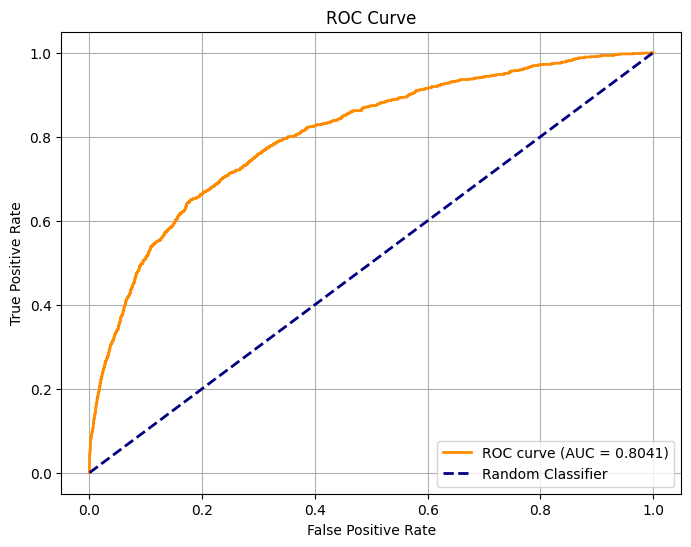

In [21]:
# draw roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()